In [1]:
import numpy as np
from math import sqrt
from numpy import concatenate
import matplotlib.pyplot as plt
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
#%matplotlib notebook

Using TensorFlow backend.


In [2]:
# fix random seed for reproducibility
np.random.seed(7)

In [4]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [5]:
# load dataset
dataset = read_csv('Treasury_ML(15yr).csv', index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,1] = encoder.fit_transform(values[:,1])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[3]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)   var1(t)
1   0.444444   0.984456  0.442529
2   0.442529   0.979275  0.442529
3   0.442529   0.979275  0.442529
4   0.442529   0.979275  0.446360
5   0.446360   0.974093  0.446360


In [6]:
# split into train and test sets
values = reframed.values
n_train_hours = int(len(reframed)*0.67)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(3670, 1, 2) (3670,) (1809, 1, 2) (1809,)


W0827 13:11:51.619517  8760 deprecation_wrapper.py:119] From C:\Program Files\Anaconda3\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0827 13:11:51.641515  8760 deprecation_wrapper.py:119] From C:\Program Files\Anaconda3\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0827 13:11:51.645515  8760 deprecation_wrapper.py:119] From C:\Program Files\Anaconda3\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0827 13:11:51.990500  8760 deprecation_wrapper.py:119] From C:\Program Files\Anaconda3\envs\tensorflow\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0827 13

Train on 3670 samples, validate on 1809 samples
Epoch 1/100
 - 3s - loss: 0.2970 - val_loss: 0.0821
Epoch 2/100
 - 0s - loss: 0.2062 - val_loss: 0.1414
Epoch 3/100
 - 0s - loss: 0.1764 - val_loss: 0.1058
Epoch 4/100
 - 0s - loss: 0.1485 - val_loss: 0.0721
Epoch 5/100
 - 0s - loss: 0.1138 - val_loss: 0.0320
Epoch 6/100
 - 0s - loss: 0.0740 - val_loss: 0.0227
Epoch 7/100
 - 0s - loss: 0.0300 - val_loss: 0.0495
Epoch 8/100
 - 0s - loss: 0.0206 - val_loss: 0.0373
Epoch 9/100
 - 0s - loss: 0.0202 - val_loss: 0.0374
Epoch 10/100
 - 0s - loss: 0.0197 - val_loss: 0.0374
Epoch 11/100
 - 0s - loss: 0.0210 - val_loss: 0.0382
Epoch 12/100
 - 0s - loss: 0.0277 - val_loss: 0.0398
Epoch 13/100
 - 0s - loss: 0.0521 - val_loss: 0.0210
Epoch 14/100
 - 0s - loss: 0.0216 - val_loss: 0.0417
Epoch 15/100
 - 0s - loss: 0.0218 - val_loss: 0.0389
Epoch 16/100
 - 0s - loss: 0.0293 - val_loss: 0.0349
Epoch 17/100
 - 0s - loss: 0.0460 - val_loss: 0.0214
Epoch 18/100
 - 0s - loss: 0.0274 - val_loss: 0.0412
Epoch 1

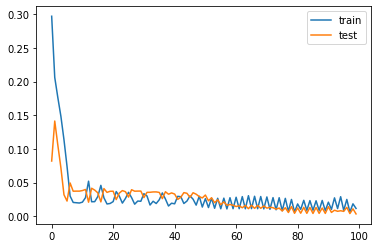

In [7]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, 
                    validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [8]:
# make a prediction
yhat = model.predict(test_X)
train_yhat = model.predict(train_X)
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[2]))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[2]))

In [9]:
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

inv_train_yhat = concatenate((train_yhat, train_X[:, 1:]), axis=1)
inv_train_yhat = scaler.inverse_transform(inv_train_yhat)
inv_train_yhat = inv_train_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

train_y = train_y.reshape((len(train_y), 1))
inv_train_y = concatenate((train_y, train_X[:, 1:]), axis=1)
inv_train_y = scaler.inverse_transform(inv_train_y)
inv_train_y = inv_train_y[:,0]

# calculate RMSE
train_rmse = sqrt(mean_squared_error(inv_train_y, inv_train_yhat))
print('Train RMSE: %.4f' % train_rmse)
test_rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.4f' % test_rmse)

Train RMSE: 0.1914
Test RMSE: 0.0268


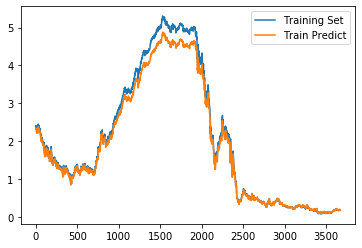

Training set accuracy: 94.86990869045258%


In [10]:
plt.plot(inv_train_y, label = 'Training Set')
plt.plot(inv_train_yhat, label = 'Train Predict')
plt.legend()
plt.show()
print('Training set accuracy:',
      '{}%'.format(100-np.mean(abs(inv_train_y-inv_train_yhat)/inv_train_y)*100,'%'))

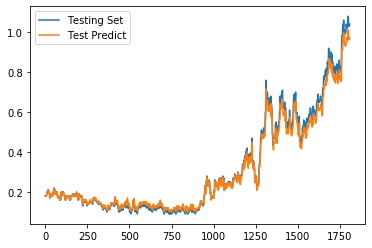

Testing set accuracy: 93.86265985667706%


In [11]:
plt.plot(inv_y, label = 'Testing Set')
plt.plot(inv_yhat, label = 'Test Predict')
plt.legend()
plt.show()
print('Testing set accuracy:',
      '{}%'.format(100-np.mean(abs(inv_y-inv_yhat)/inv_y)*100,'%'))